# Local Volatility Model

### Yin Fu -- yf2315@nyu.edu

We use the SPX opton data with maturity from 2022.5 to 2026.12 (current all available months, choose one day per month) and all available strike prices on that day for constructing the implied volatility and local volatility surface. The reason for choosing the maturity for one day per month is to make the observation more evenly distributed along the axis of maturity axis. Different maturities available on the market are tend to be more clusted when the options are closer to expire date. By making observation for at most one maturity per month, we guarantee some space between volatility smiles.

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import math
import warnings
from statistics import mean
from scipy.stats import norm
from scipy.optimize import brentq, least_squares
from scipy.interpolate import RegularGridInterpolator
#from mpl_toolkits.mplot3d import axes3d  

#warnings.filterwarnings("ignore")

In [2]:
# Initial stock price
S0 = 4271.78                        # Latest trading records (up to 2022.4.24)
t0 = dt.datetime(2022,4,24,0,0)
r = 0.5/100                         # FED Federal Funds Rate, American central bank’s interest rate

In [3]:
def call_opt(S, T, K, r, q, sig):
    """
    The Original Black-scholes formula
    """
    
    FT = S*np.exp((r-q)*T)
    
    d_1 = 1/(sig*math.sqrt(T)) * np.log(FT/K) + sig*math.sqrt(T)/2
    d_2 = 1/(sig*math.sqrt(T)) * np.log(FT/K) - sig*math.sqrt(T)/2
    
    return S*np.exp(-q*T)*norm.cdf(d_1) - K*np.exp(-r*T)*norm.cdf(d_2)

def put_opt(S, T, K, r, q, sig):
    """
    From the Black-choles formula and the put-call parity
    """
    return call_opt(S, T, K, r, q, sig) + np.exp(-r*T)*K - np.exp(-q*T)*(S)

Here, we choose the latest trading record as the spot price of the stock since we observe that the bid-ask spread is about $\$697$ which is too wide so we choose not to use the mid point of the bid-ask price as the spot price. Moreover, we choose the FRA rate as our interest rate since most of the option available on the market have mid-term maturity(less than 5 years). In addition, we will choose the dividend yield to be the implied dividend computed by the put-call parity.

Now, we try to parse the data. Below is an illustration of how we produce the SVI for maturity at 2022.5, and we will use loops for the rest of slices to generate the whole implied volatility surface.

### 0.5 Implied vol and SVI for one slice (maturity at 2022.5.2 and all strikes)

Here we we use the Raw SVI parametrization to fit the implied vol on a smooth curve. For computing the implied volatility, $\sigma_{implied}$, we use the OTM put and OTM call options for the liquidity consideration(also for the rest of the data).

In [4]:
def Raw_SVI(logK, params):
    """
    Implementation of Raw SVI parametrization
    """
    a = params[0]
    b = params[1]
    rho = params[2]
    m = params[3]
    sig = params[4]
    
    return a+b*(rho*(logK-m)+np.sqrt((logK-m)**2+sig**2))

def SVI_residual_vec(params, logK_train, w_train):
    """
    The residual function for the SVI parameter estimation
    """
    
    logK_train = np.array(logK_train)
    w_train = np.array(w_train)
    
    return Raw_SVI(logK_train, params) - w_train

In [5]:
# Read the data
df = pd.read_csv('spx_quotedata.csv')
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])
 

# Filter the data to a specific maturity
T_date = df['Expiration Date'][0]
df = df[df['Expiration Date'] == T_date]

# splite the call and put dataframe
cols = list(df.columns)
put_idx = cols.index('Puts')
cols_call = ['Strike','Bid', 'Ask', 'IV']
cols_put = ['Strike','Bid.1', 'Ask.1', 'IV.1'] 
#cols_call = cols[:put_idx]
#cols_put = cols[put_idx-1:]

df_call = df[cols_call].copy()
df_put = df[cols_put].copy()
strike = df['Strike'].copy()

# add the price column to the put and call dataframe
df_call['Price'] = (df_call['Bid'] + df_call['Ask'])/2
df_put['Price'] = (df_put['Bid.1'] + df_put['Ask.1'])/2

# Find T in BS
BD_counts = np.busday_count(t0.date(), T_date.to_pydatetime().date())
T = BD_counts/252

# Find the implied dividend q
df['dif'] = abs(df['Strike'] - S0)
closest_idx = list(df['dif']).index(min(df['dif']))

K_ATM = list(df['Strike'])[closest_idx]
q = np.log(((df_call['Price'][closest_idx] - df_put['Price'][closest_idx]) + K_ATM*np.exp(-r*T))/S0)/T * (-1)
# a = df_call['Price'][closest_idx] - df_put['Price'][closest_idx] + K_ATM*np.exp(-r*T)

# Filter the data for OTM calls and OTM puts
df_call = df_call[df_call['Strike']>=S0].copy()
df_put = df_put[df_put['Strike']<=S0].copy()

# Estimates the implied vol
IV_calc = []
for i in range(df_put.shape[0]):
    f_put = lambda s: put_opt(S=S0, T=T, K=list(df_put['Strike'])[i], r=r, q=q, sig=s) - list(df_put['Price'])[i]
    iv = brentq(f_put, 1e-6, 3)
    IV_calc.append(iv)

for i in range(df_call.shape[0]):
    f_call = lambda s: call_opt(S=S0, T=T, K=list(df_call['Strike'])[i], r=r, q=q, sig=s) - list(df_call['Price'])[i]
    iv = brentq(f_call, 1e-6, 3)
    IV_calc.append(iv)

# log strike price
FT = S0*np.exp((r-q)*T)
logKs = [np.log(K/FT) for K in df['Strike']]

# Total implied variance
w_obs = [iv*iv*T for iv in IV_calc]

# Least-square for estimating the parameter
res = least_squares(SVI_residual_vec, x0=np.array([0, 1, 0.5, 1, 1]), 
                           args=(logKs, w_obs),
                           bounds=([-np.inf, 0, -1+1e-10, -np.inf, 1e-10],[np.inf, np.inf, 1-(1e-10), np.inf, np.inf]))
opt_params = res.x
K_SVI_plot = np.arange(df['Strike'].min(), df['Strike'].max()+1, 1)
logK_SVI_plot = [np.log(K/FT) for K in K_SVI_plot]
IV_SVI_plot = np.sqrt(Raw_SVI(logK_SVI_plot, opt_params)/T)

In [6]:
res.x

array([-4.08687763,  0.77636246,  0.16449585,  0.9692498 ,  5.33846082])

<IPython.core.display.Javascript object>


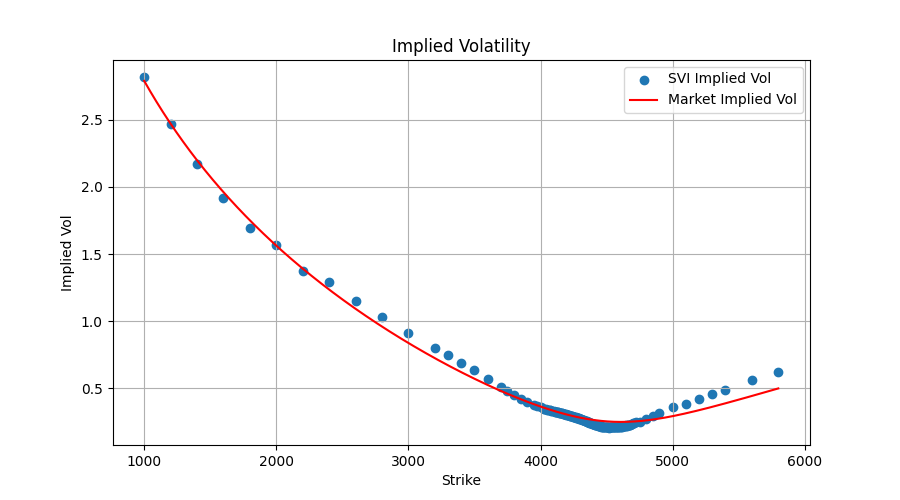

In [7]:
# plot the implied vol with the SVI
fig = plt.figure(figsize=(9, 5))

plt.scatter(df['Strike'], IV_calc)
plt.plot(K_SVI_plot, IV_SVI_plot, c='r')
plt.xlabel('Strike')
plt.ylabel('Implied Vol')
plt.legend(['SVI Implied Vol', 'Market Implied Vol'])
plt.title('Implied Volatility')
plt.grid()
plt.show()

We observe that the Raw SVI parametrization doesn't match the market implied vol perfectly(but hopefully close enough). This is because there are only 5 parameters in the model for fitting the data.

### 1.0 Implied vol and SVI for all option prices (matruity 2022.5 - 2026.12 and all available strikes)
__But here we will only plot for matruity up until 2023.1 since the plot will be hard to see if we use too much data__

__**Constructing the implied volatility surface**__

We will use the Raw SVI along the strike axis for each slices(maturity), and then we will do a linear interpolation along the maturity axis as we discussed in the lecture that it is (in most cases) sufficient to prevent the calendar arbitrage using the linear interpolation.

Now, we make the above calculation process into a function.

In [34]:
def implied_vol(file_path, K_min=50, K_max=7450, space=1):
    # Read the data
    df = pd.read_csv(file_path)
    df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])
    #df = df[(df['Strike']>= 2000) & (df['Strike']<= 6500)].copy()

    # Filter the data to a specific maturity
    T_date = df['Expiration Date'][0]
    df = df[df['Expiration Date'] == T_date]

    # splite the call and put dataframe
    cols = list(df.columns)
    put_idx = cols.index('Puts')
    cols_call = ['Strike','Bid', 'Ask', 'IV']
    cols_put = ['Strike','Bid.1', 'Ask.1', 'IV.1'] 
    #cols_call = cols[:put_idx]
    #cols_put = cols[put_idx-1:]

    df_call = df[cols_call].copy()
    df_put = df[cols_put].copy()
    strike = df['Strike'].copy()

    # add the price column to the put and call dataframe
    df_call['Price'] = (df_call['Bid'] + df_call['Ask'])/2
    df_put['Price'] = (df_put['Bid.1'] + df_put['Ask.1'])/2

    # Find T in BS
    BD_counts = np.busday_count(t0.date(), T_date.to_pydatetime().date())
    T = BD_counts/252

    # Find the implied dividend q
    df['dif'] = abs(df['Strike'] - S0)
    closest_idx = list(df['dif']).index(min(df['dif']))

    K_ATM = list(df['Strike'])[closest_idx]
    q = np.log(((df_call['Price'][closest_idx] - df_put['Price'][closest_idx]) + K_ATM*np.exp(-r*T))/S0)/T * (-1)
    # a = df_call['Price'][closest_idx] - df_put['Price'][closest_idx] + K_ATM*np.exp(-r*T)

    # Filter the data for OTM calls and OTM puts
    df_call = df_call[df_call['Strike']>=S0].copy()
    df_put = df_put[df_put['Strike']<=S0].copy()

    # Estimates the implied vol
    IV_calc = []
    for i in range(df_put.shape[0]):
        f_put = lambda s: put_opt(S=S0, T=T, K=list(df_put['Strike'])[i], r=r, q=q, sig=s) - list(df_put['Price'])[i]
        iv = brentq(f_put, 1e-6, 3)
        IV_calc.append(iv)

    for i in range(df_call.shape[0]):
        f_call = lambda s: call_opt(S=S0, T=T, K=list(df_call['Strike'])[i], r=r, q=q, sig=s) - list(df_call['Price'])[i]
        iv = brentq(f_call, 1e-6, 3)
        IV_calc.append(iv)
        
    # log strike price
    FT = S0*np.exp((r-q)*T)
    logKs = [np.log(K/FT) for K in df['Strike']]

    # Total implied variance
    w_obs = [iv*iv*T for iv in IV_calc]

    # Least-square for estimating the SVI parameter -- interpolation along K axis
    res = least_squares(SVI_residual_vec, x0=np.array([0, 1, 0.5, 1, 1]), 
                           args=(logKs, w_obs),
                           bounds=([-np.inf, 0, -1+1e-10, -np.inf, 1e-10],[np.inf, np.inf, 1-(1e-10), np.inf, np.inf]))
    opt_params = res.x
    K_SVI_plot = np.arange(K_min, K_max, space)
    logK_SVI_plot = [np.log(K/FT) for K in K_SVI_plot]
    IV_SVI_plot = np.sqrt(Raw_SVI(logK_SVI_plot, opt_params)/T)
    
    return len(IV_calc)*[T], list(df['Strike']), IV_calc, np.ones(len(K_SVI_plot))*T, K_SVI_plot, IV_SVI_plot, q

In [35]:
# Specify the parameter for interpolation
n_files = 9
K_min = 50                               # minimum value for K in SVI
K_max = 7500                             # Maximum value for K in SVI
space = 1                                # Space between each K
nK = int((K_max - K_min)/space)          # Total number of K for each T

# Data for plotting the implied vol surface
# RAW SVI along K
file_names = ['spx_quotedata'+str(i+1)+'.csv' for i in range(n_files)]
Ts = []                                  # Flat array for plotting
Strikes = []                             # Flat array for plotting
IVs = []                                 # Flat array for plotting
qs = []

Ts_SVI = np.zeros(shape=(n_files, nK))   # Meshgrid
Ks_SVI = np.zeros(shape=(n_files, nK))   # Meshgrid
IVs_SVI = np.zeros(shape=(n_files, nK))  # Meshgrid

for j in range(n_files):
    
    T, K, IV, T_SVI, K_SVI, IV_SVI, q = implied_vol(file_names[j], K_min=K_min, K_max=K_max, space=space)
    
    for i in range(len(K)):
        Ts.append(T[i])
        Strikes.append(K[i])
        IVs.append(IV[i])
        
    Ts_SVI[j,:] = T_SVI
    Ks_SVI[j,:] = K_SVI
    IVs_SVI[j,:] = IV_SVI
    qs.append(q)
    
# Linear interpolation along T
nT = 300
Ts_interp = np.linspace(min(Ts), max(Ts), nT)  # Flat array for generating Meshgrid
Ks_interp = K_SVI                              # Flat array for generating Meshgrid 
TT_interp, KK_interp = np.meshgrid(Ts_interp, Ks_interp)

SVI_interpolating_function = RegularGridInterpolator((Ts_SVI[:,0], Ks_SVI[0, :]), IVs_SVI)
TK_interp_pts = np.row_stack((TT_interp.flatten(order="F"), KK_interp.flatten(order='F'))).T
IVs_interp = SVI_interpolating_function(np.row_stack(TK_interp_pts))

# Small adjustments for plotting
TT_interp = TT_interp.T
KK_interp = KK_interp.T
#IVs_interp = IVs_interp.reshape(nT, nK)


<IPython.core.display.Javascript object>


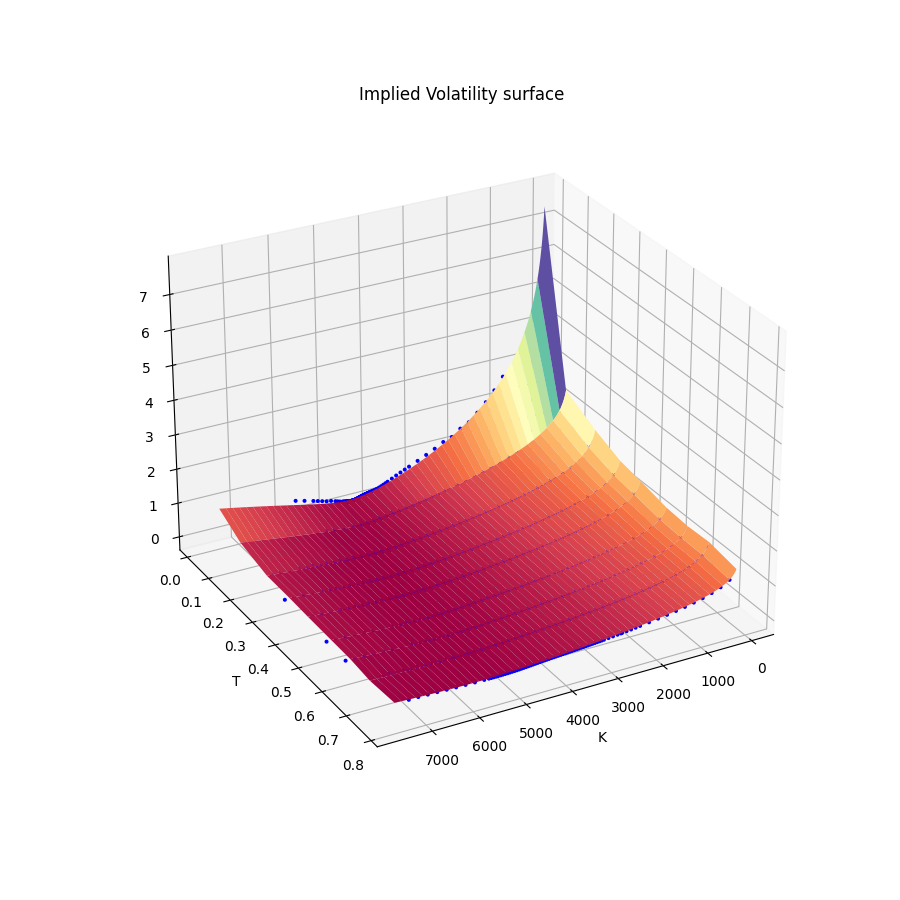

In [10]:
fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection='3d')


ax.scatter(Strikes, Ts, IVs, c='b', alpha=1, s=3.5)
ax.plot_surface(Ks_SVI, Ts_SVI, IVs_SVI, cmap=plt.cm.Spectral)
#ax.plot_surface(KK_interp, TT_interp, IVs_interp.reshape(nT, nK), cmap=plt.cm.Spectral)
plt.xlabel('K')
plt.ylabel('T')
plt.title('Implied Volatility surface')

plt.show()

We see that the above plot is indeed a 'typical-looking' implied volatility surface.

### 2.0 Local Volatility Surface

First, calculate the call price surface (call price as a function of $K$, $T$ and the correponding $\sigma_{implied}$).
Moreover, we will use the the mean dividend $q = E[q_{implied}]$ estimated for different matruity.

Then we will use the Dupire equation to find the local volatility

$$
    \sigma_{LV}(S, t)^2 = 2\frac{\frac{dC}{dT}+qC+(r-q)K\frac{dC}{dK}}{K^2\frac{d^2C}{dK^2}} \biggr\rvert_{K=S, T=t}
$$

using finite difference method.

Although the SVI parametrization should avoid the arbitrage issues theoretically, we will make some small adjustments if the actual computation violates the no arbitrage condition due the numerical issues/instability, problematic arbitrage opportunity might be the following
$$
    \frac{dC}{dK} > 0
$$
and
$$
    \frac{dC}{dT} < 0
$$
and
$$
    \frac{d^2C}{dK^2} < 0
$$

In [11]:
C = []
for i in range(nT*nK):
    V = call_opt(S=S0, T=TK_interp_pts[i,0], K=TK_interp_pts[i, 1], r=r, q=mean(qs), sig=IVs_interp[i])
    C.append(V)

In [12]:
C = np.array(C).reshape(nT, nK)

In [42]:
dT = Ts_interp[1]-Ts_interp[0]
dK = 1

def dCdT(C, dT=dT):
    """
    Compute the derivative of C w.r.t. T given the grid of C using finite different method
    we choose dT to be the difference between the adjacent discretized T when computing
    the price matrix C.
    
    Use the central difference
    """
    dCdT = np.zeros(shape=C.shape)
    for i in range(0+1, C.shape[0]-1):
        for j in range(0+1, C.shape[1]-1):
            val = abs((C[i+1,j] - C[i-1,j])/(2*dT))
            dCdT[i, j] = val
            
    return dCdT[1:-1, 1:-1]

def dCdK(C, dK=dK):
    """
    Compute the derivative of C w.r.t. K given the grid of C using finite different method
    we choose dK to be the difference between the adjacent discretized K when computing
    the price matrix C.
    
    Use the central difference
    """
    dCdK = np.zeros(shape=C.shape)
    for i in range(0+1, C.shape[0]-1):
        for j in range(0+1, C.shape[1]-1):
            val = -abs((C[i,j+1] - C[i,j-1])/(2*dK))
            dCdK[i, j] = val
            
    return dCdK[1:-1, 1:-1]

def d2CdK2(C, dK=dK):
    """
    Compute the 2nd derivative of C w.r.t. K given the grid of C using finite different method
    we choose dK to be the difference between the adjacent discretized K when computing
    the price matrix C.
    
    Use the central difference
    """
    dC2dK2 = np.zeros(shape=C.shape)
    for i in range(0+1, C.shape[0]-1):
        for j in range(0+1, C.shape[1]-1):
            val = abs((C[i,j+1] - 2*C[i,j] + C[i,j-1])/(dK*dK))
            dC2dK2[i, j] = val
            
    return dC2dK2[1:-1, 1:-1]

def Local_Vol(C, Ks_interp, r=r, q=mean(qs), dK=dK, dT=dT):
    """
    Compute the local volatility
    """
    local_vol = np.zeros(shape=(C.shape[0]-2, C.shape[1]-2))
    K = Ks_interp[1:-1]
    dCdK_m = dCdK(C, dK=dK)
    dCdT_m = dCdT(C, dT=dT)
    d2CdK2_m = d2CdK2(C, dK=dK)
    for i in range(C.shape[0]-2):
        for j in range(C.shape[1]-2):
            numer = dCdT_m[i, j] + q*C[i, j] + (r-q)*K[j]*dCdK_m[i,j]
            denom = K[j]**2*d2CdK2_m[i, j]
            local_vol[i, j] = np.sqrt(2*numer/denom)
    return local_vol

In [56]:
# plot part of the local vol surface by truncating the vector
T_trunc = 0
K_trunc = 2420

sig_LV = Local_Vol(C[T_trunc:, K_trunc:], Ks_interp[K_trunc:])

<IPython.core.display.Javascript object>


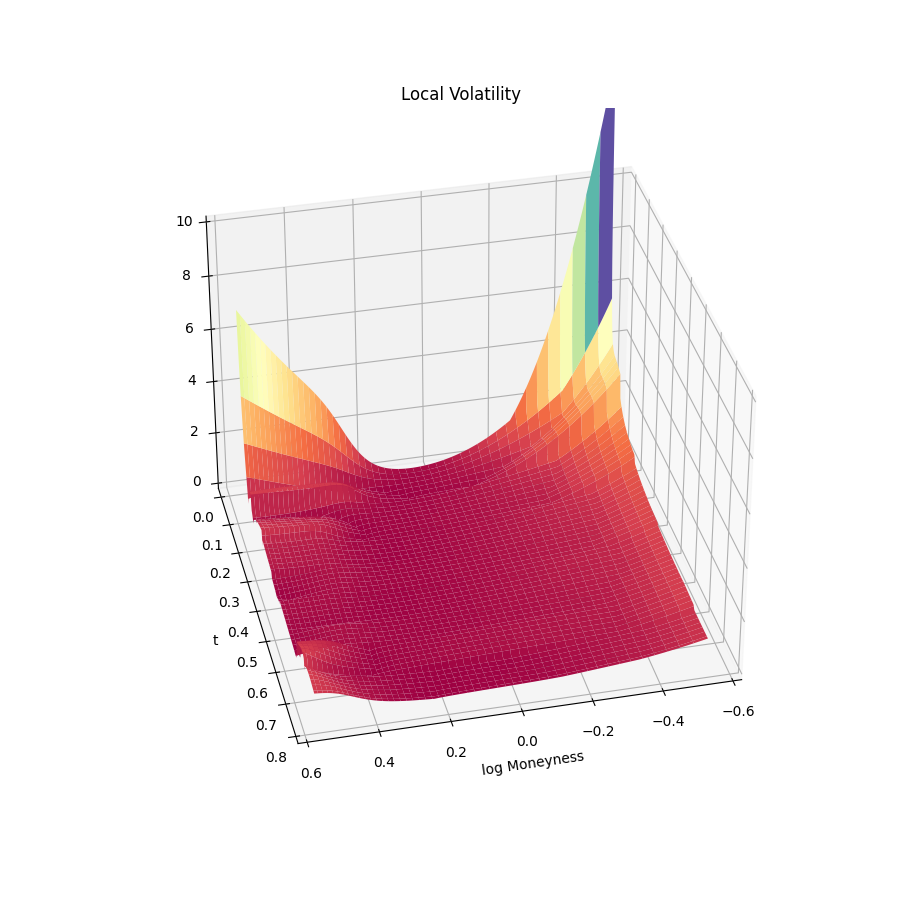

In [57]:
# plot the local volatility surface

TT_LV = TT_interp[T_trunc+1:-1, K_trunc+1:-1]
KK_LV = KK_interp[T_trunc+1:-1, K_trunc+1:-1]

fig2 = plt.figure(figsize=(9, 9))
ax2 = plt.axes(projection='3d')
ax2.plot_surface(np.log(KK_LV/S0), TT_LV, sig_LV, cmap=plt.cm.Spectral)
ax2.set_xlim(-0.6, 0.6)
ax2.set_zlim(0, 10)
plt.xlabel('log Moneyness')
plt.ylabel('t')
plt.title('Local Volatility')
plt.show()